# Objetivo
Ser capaz de identificar clientes de alta renda (>50K) a partir de seus dados demograficos, socio economico e cadastro utilizando modelos de classificação. 
O dataset utilizado contém informações fictícias apenas para efeitos acadêmicos. 
Fonte: https://www.kaggle.com/uciml/adult-census-income

O tipo de modelo escolhido foi de Regressão Logística uma vez que a variável que queremos prever  é binária (>50K ou <=50K).
Através do modelo, será possível segmentar clientes do banco utilizando dados que podem ser disponibilizados pelas APIs do Open Banking. 
O intuito ao utilizar o modelo é oferecer melhores serviços e produtos baseado na renda do cliente.

import pymongo

In [1]:
!pip install imblearn

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from pymongo import MongoClient

In [3]:
sns.set()

In [4]:
#Adicionando conexão com mongo
client = MongoClient("mongodb", 27017)

In [5]:
#Carregando database
db = client.raw

In [6]:
#Carregando Collection
dados = db.adults

In [7]:
#Gerando cursor com toda a collection
cursor = dados.find()

In [8]:
#Gerando um Dataframe do Panda
data = pd.DataFrame(list(cursor))

In [9]:
data.head()

,_id,income,finalWeight,education,occupation,hoursPerWeek,race,sex,educationNum,capitalLoss,nativeCountry,workClass,capitalGain,relationship,age,maritalStatus
0,611ec45e1fa0ee34a63c55cd,<=50k,77516,bachelors,adm-clerical,40,white,male,13,0.0,united-states,state-gov,2174.0,not-in-family,39,never-married
1,611ec45f1fa0ee34a63c55ce,<=50k,83311,bachelors,exec-managerial,13,white,male,13,0.0,united-states,self-emp-not-inc,0.0,husband,50,married-civ-spouse
2,611ec45f1fa0ee34a63c55cf,<=50k,215646,hs-grad,handlers-cleaners,40,white,male,9,0.0,united-states,private,0.0,not-in-family,38,divorced
3,611ec45f1fa0ee34a63c55d0,<=50k,338409,bachelors,prof-specialty,40,black,female,13,0.0,cuba,private,0.0,wife,28,married-civ-spouse
4,611ec45f1fa0ee34a63c55d1,<=50k,160187,9th,other-service,16,black,female,5,0.0,jamaica,private,0.0,not-in-family,49,married-spouse-absent


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   _id            32561 non-null  object 
 1   income         32561 non-null  object 
 2   finalWeight    32561 non-null  int64  
 3   education      32561 non-null  object 
 4   occupation     32561 non-null  object 
 5   hoursPerWeek   32561 non-null  int64  
 6   race           32561 non-null  object 
 7   sex            32561 non-null  object 
 8   educationNum   32561 non-null  int64  
 9   capitalLoss    32561 non-null  float64
 10  nativeCountry  32561 non-null  object 
 11  workClass      32561 non-null  object 
 12  capitalGain    32561 non-null  float64
 13  relationship   32561 non-null  object 
 14  age            32561 non-null  int64  
 15  maritalStatus  32561 non-null  object 
dtypes: float64(2), int64(4), object(10)
memory usage: 4.0+ MB


# Verificar os campos para dados null ou com inconsistências

Apesar de mostrar que o dataset não há valores null, percebe-se que existem campos valor '?' nas variáveis nativeCountry, workclass e occupation

In [11]:
data['occupation'].unique()

array(['adm-clerical', 'exec-managerial', 'handlers-cleaners',
       'prof-specialty', 'other-service', 'craft-repair',
       'farming-fishing', 'machine-op-inspct', 'sales',
       'transport-moving', 'tech-support', '?', 'protective-serv',
       'priv-house-serv', 'armed-forces'], dtype=object)

In [12]:
data['workClass'].unique()

array(['state-gov', 'self-emp-not-inc', 'private', 'local-gov', '?',
       'federal-gov', 'self-emp-inc', 'without-pay', 'never-worked'],
      dtype=object)

Analise das outras variáveis

In [13]:
data['age'].unique()

array([39, 50, 38, 28, 49, 52, 31, 42, 37, 23, 40, 25, 32, 54, 43, 56, 48,
       53, 41, 18, 46, 35, 30, 57, 34, 47, 17, 22, 19, 20, 36, 44, 64, 29,
       26, 24, 59, 60, 33, 45, 27, 51, 21, 76, 61, 67, 55, 65, 79, 71, 68,
       58, 66, 62, 75, 63, 90, 74, 70, 73, 69, 78, 80, 72, 77, 88, 82, 81,
       83, 84, 85, 86, 87])

In [14]:
data['education'].unique()

array(['bachelors', 'hs-grad', '9th', 'masters', 'some-college',
       'assoc-voc', '11th', 'assoc-acdm', '5th-6th', '7th-8th',
       'doctorate', '10th', '1st-4th', '12th', 'prof-school', 'preschool'],
      dtype=object)

In [15]:
data['maritalStatus'].unique()

array(['never-married', 'married-civ-spouse', 'divorced',
       'married-spouse-absent', 'separated', 'widowed',
       'married-af-spouse'], dtype=object)

In [16]:
data['relationship'].unique()

array(['not-in-family', 'husband', 'wife', 'own-child', 'unmarried',
       'other-relative'], dtype=object)

In [17]:
data['race'].unique()

array(['white', 'black', 'asian-pac-islander', 'other',
       'amer-indian-eskimo'], dtype=object)

In [18]:
data['sex'].unique()

array(['male', 'female'], dtype=object)

In [19]:
data['income'].unique() 

array(['<=50k', '>50k'], dtype=object)

In [20]:
data['finalWeight'].unique() 

array([ 77516,  83311, 215646, ..., 252208,  34066, 257302])

In [21]:
data['hoursPerWeek'].unique() 

array([40, 13, 16, 45, 50, 80, 30, 35, 20, 60, 52, 38, 48, 32, 41, 28, 36,
       24, 42, 55, 56,  6, 25, 44, 18, 15, 43, 34, 54, 33,  8, 70, 10, 46,
       39, 21, 65,  3, 84,  4, 37,  1, 47, 64, 19, 12,  7, 90, 75, 58, 14,
       27, 11,  9, 99,  5,  2, 17, 53, 68, 72, 26, 78, 49, 22, 59, 62, 98,
       66, 85, 57, 31, 51, 77, 63, 23, 88, 73, 87, 89, 97, 94, 29, 96, 67,
       82, 86, 91, 81, 76, 92, 61, 74, 95])

In [22]:
data['educationNum'].unique() 

array([13,  9,  5, 14, 10, 11,  7, 12,  3,  4, 16,  6,  2,  8, 15,  1])

In [23]:
data['capitalLoss'].unique() 

array([   0., 2042., 1719., 2415., 1408., 1980., 1573., 1902., 1741.,
       1887., 1977., 1340., 1579., 2339., 1848., 2377., 1721., 1669.,
        653., 1876., 2206., 1564., 2547., 2002., 1602., 1485., 1672.,
       1590., 2258., 1380., 2392., 1762.,  419., 1138., 2179., 1740.,
       2051., 1628., 1726., 2205., 1504., 1651.,  625., 2238.,  213.,
       1816., 2001., 2174., 2444., 2352., 1539.,  880., 1668., 1594.,
       1092., 3004., 2231., 1844., 2824.,  810., 2559., 2057., 1974.,
        974., 2149., 1825., 1735., 2129., 2603., 1258., 2282.,  323.,
       4356., 2246., 1648., 1617., 2489., 3770., 1755., 3683., 2267.,
       2080., 2457.,  155., 3900., 2201., 1944., 2467., 2163., 2754.,
       2472., 1411.])

In [24]:
data['capitalGain'].unique() 

array([ 2174.,     0., 14084.,  5178.,  2407., 34095.,  4386., 14344.,
        7688.,  2176., 15024.,  7298., 20051.,  3674.,  4064.,  1409.,
        1055.,  3103., 99999.,  1506., 13550.,  6767.,  8614.,  4865.,
        3411.,   594.,  2463.,  3325.,  6514.,  3471.,   914.,  2961.,
        2829.,  5013.,  4101.,  2635., 27828.,  2228.,  5556.,  4787.,
        1111., 10520.,  3137.,  2597.,  4650.,  2105., 10605., 25124.,
        2580.,  1471.,  2329.,  2050.,  2964.,  2202.,  6849.,   401.,
        2977.,  2885., 15020.,  3818.,  3942.,  3464., 25236.,  9386.,
        4416., 10566.,  3781.,  4934.,  2062.,  2354.,  5455.,  1424.,
        3273., 22040.,  3908.,  4931.,   991.,  1086.,  7430.,  6497.,
         114.,  7896.,  2346.,  3418.,  3432.,  2907.,  1151.,  2414.,
        2290., 15831., 41310.,  4508.,  2538.,  3456.,  6418.,  1848.,
        3887.,  5721.,  9562.,  1455.,  2036.,  1831., 11678.,  2936.,
        2993.,  7443.,  6360.,  1797.,  1173.,  4687.,  2009.,  6723.,
      

# Tratando dados null e ou inconsistêntes

Vamos substituir os valores '?' de todo dataframe para NaN.

In [25]:
data = data.replace('?', np.nan)
data.head()

,_id,income,finalWeight,education,occupation,hoursPerWeek,race,sex,educationNum,capitalLoss,nativeCountry,workClass,capitalGain,relationship,age,maritalStatus
0,611ec45e1fa0ee34a63c55cd,<=50k,77516,bachelors,adm-clerical,40,white,male,13,0.0,united-states,state-gov,2174.0,not-in-family,39,never-married
1,611ec45f1fa0ee34a63c55ce,<=50k,83311,bachelors,exec-managerial,13,white,male,13,0.0,united-states,self-emp-not-inc,0.0,husband,50,married-civ-spouse
2,611ec45f1fa0ee34a63c55cf,<=50k,215646,hs-grad,handlers-cleaners,40,white,male,9,0.0,united-states,private,0.0,not-in-family,38,divorced
3,611ec45f1fa0ee34a63c55d0,<=50k,338409,bachelors,prof-specialty,40,black,female,13,0.0,cuba,private,0.0,wife,28,married-civ-spouse
4,611ec45f1fa0ee34a63c55d1,<=50k,160187,9th,other-service,16,black,female,5,0.0,jamaica,private,0.0,not-in-family,49,married-spouse-absent


Na tabela abaixo, nota-se que existem 3 variáveis como NA

In [26]:
data.isna().sum()

_id                 0
income              0
finalWeight         0
education           0
occupation       1843
hoursPerWeek        0
race                0
sex                 0
educationNum        0
capitalLoss         0
nativeCountry     583
workClass        1836
capitalGain         0
relationship        0
age                 0
maritalStatus       0
dtype: int64

Para as variáveis Workclass e Occupation podemos verificar a dependências

In [27]:
data[data['workClass'].isna()]['occupation'].unique()

array([nan], dtype=object)

In [28]:
data[data['occupation'].isna()]['income'].value_counts()

<=50k    1652
>50k      191
Name: income, dtype: int64

Nota-se que os NaN em workclass depende de occupation (como esperado) - tipo MAR (Missing at Random). 
Sendo assim, podemos afirmar que os valores NaN são de pessoas desempregadas, dessa forma, pode-se substituir NaN para "Unemployee"

In [29]:
data['occupation'] = data['occupation'].fillna('unemployed')
data['workClass'] = data['workClass'].fillna('unemployed')
data.head()

,_id,income,finalWeight,education,occupation,hoursPerWeek,race,sex,educationNum,capitalLoss,nativeCountry,workClass,capitalGain,relationship,age,maritalStatus
0,611ec45e1fa0ee34a63c55cd,<=50k,77516,bachelors,adm-clerical,40,white,male,13,0.0,united-states,state-gov,2174.0,not-in-family,39,never-married
1,611ec45f1fa0ee34a63c55ce,<=50k,83311,bachelors,exec-managerial,13,white,male,13,0.0,united-states,self-emp-not-inc,0.0,husband,50,married-civ-spouse
2,611ec45f1fa0ee34a63c55cf,<=50k,215646,hs-grad,handlers-cleaners,40,white,male,9,0.0,united-states,private,0.0,not-in-family,38,divorced
3,611ec45f1fa0ee34a63c55d0,<=50k,338409,bachelors,prof-specialty,40,black,female,13,0.0,cuba,private,0.0,wife,28,married-civ-spouse
4,611ec45f1fa0ee34a63c55d1,<=50k,160187,9th,other-service,16,black,female,5,0.0,jamaica,private,0.0,not-in-family,49,married-spouse-absent


tratamento do campo NativeCountry

In [30]:
data[data['nativeCountry'].isna()]

,_id,income,finalWeight,education,occupation,hoursPerWeek,race,sex,educationNum,capitalLoss,nativeCountry,workClass,capitalGain,relationship,age,maritalStatus
10,611ec45f1fa0ee34a63c55d7,>50k,121772,assoc-voc,craft-repair,40,asian-pac-islander,male,11,0.0,NaN,private,0.0,husband,40,married-civ-spouse
19,611ec45f1fa0ee34a63c55e0,>50k,84154,some-college,sales,38,white,male,10,0.0,NaN,private,0.0,husband,31,married-civ-spouse
24,611ec45f1fa0ee34a63c55e5,<=50k,226956,hs-grad,other-service,30,white,female,9,0.0,NaN,private,0.0,own-child,18,never-married
30,611ec45f1fa0ee34a63c55eb,<=50k,293936,7th-8th,unemployed,40,white,male,4,0.0,NaN,unemployed,0.0,not-in-family,32,married-spouse-absent
59,611ec45f1fa0ee34a63c5608,<=50k,203580,hs-grad,adm-clerical,35,white,male,9,0.0,NaN,private,0.0,husband,56,married-civ-spouse
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32423,611ec5121fa0ee34a63cd474,<=50k,181974,doctorate,prof-specialty,99,white,female,16,0.0,NaN,self-emp-inc,0.0,not-in-family,58,never-married
32430,611ec5121fa0ee34a63cd47b,<=50k,199590,5th-6th,machine-op-inspct,40,white,male,3,0.0,NaN,private,0.0,husband,45,married-civ-spouse
32445,611ec5121fa0ee34a63cd48a,>50k,107302,hs-grad,prof-specialty,45,white,male,9,0.0,NaN,private,0.0,husband,39,married-civ-spouse
32454,611ec5121fa0ee34a63cd493,<=50k,120478,assoc-voc,unemployed,1,white,female,11,0.0,NaN,unemployed,0.0,unmarried,81,divorced


Análise da variável nativeCountry são falta de preenchimentp. Não há relação com outras variáveis. 
Vamos excluir os registros com 'native.country' NaN para ter um modelo não enviesado (são 583 registros).

In [31]:
data.isna().sum()

_id                0
income             0
finalWeight        0
education          0
occupation         0
hoursPerWeek       0
race               0
sex                0
educationNum       0
capitalLoss        0
nativeCountry    583
workClass          0
capitalGain        0
relationship       0
age                0
maritalStatus      0
dtype: int64

In [32]:
data.dropna(inplace = True)
data.head()

,_id,income,finalWeight,education,occupation,hoursPerWeek,race,sex,educationNum,capitalLoss,nativeCountry,workClass,capitalGain,relationship,age,maritalStatus
0,611ec45e1fa0ee34a63c55cd,<=50k,77516,bachelors,adm-clerical,40,white,male,13,0.0,united-states,state-gov,2174.0,not-in-family,39,never-married
1,611ec45f1fa0ee34a63c55ce,<=50k,83311,bachelors,exec-managerial,13,white,male,13,0.0,united-states,self-emp-not-inc,0.0,husband,50,married-civ-spouse
2,611ec45f1fa0ee34a63c55cf,<=50k,215646,hs-grad,handlers-cleaners,40,white,male,9,0.0,united-states,private,0.0,not-in-family,38,divorced
3,611ec45f1fa0ee34a63c55d0,<=50k,338409,bachelors,prof-specialty,40,black,female,13,0.0,cuba,private,0.0,wife,28,married-civ-spouse
4,611ec45f1fa0ee34a63c55d1,<=50k,160187,9th,other-service,16,black,female,5,0.0,jamaica,private,0.0,not-in-family,49,married-spouse-absent


In [33]:
data.isna().sum()

_id              0
income           0
finalWeight      0
education        0
occupation       0
hoursPerWeek     0
race             0
sex              0
educationNum     0
capitalLoss      0
nativeCountry    0
workClass        0
capitalGain      0
relationship     0
age              0
maritalStatus    0
dtype: int64

Tratamento variável target income para tornar variável qualitativa para quantitativa

In [34]:
data.replace('<=50k', 0, inplace=True)
data.replace('>50k', 1, inplace=True)

In [35]:
data['income'].value_counts(normalize=True)

0    0.759366
1    0.240634
Name: income, dtype: float64

Como 'educationNum' é uma forma numérica da coluna 'education' e a varíavel _id é criação do MongoDB, retirada para evitar enviesamento.

In [36]:
data.drop('educationNum', axis = 1,inplace = True)

In [37]:
data.drop('_id', axis = 1,inplace = True)

Simplificação dos valores de education, workclass e marital status

Variável education

In [38]:
data['education'].value_counts()

hs-grad         10368
some-college     7187
bachelors        5210
masters          1674
assoc-voc        1366
11th             1167
assoc-acdm       1055
10th              921
7th-8th           627
prof-school       559
9th               506
12th              417
doctorate         390
5th-6th           318
1st-4th           163
preschool          50
Name: education, dtype: int64

In [39]:
hs_grad = ['hs-grad','11th','10th','9th','12th']
elementary = ['1st-4th','5th-6th','7th-8th']

data['education'].replace(hs_grad,'HighSchool-grad', inplace=True)
data['education'].replace(elementary,'elementary_school', inplace=True)

data['education'].value_counts()

HighSchool-grad      13379
some-college          7187
bachelors             5210
masters               1674
assoc-voc             1366
elementary_school     1108
assoc-acdm            1055
prof-school            559
doctorate              390
preschool               50
Name: education, dtype: int64

Variável workClass

In [40]:
data['workClass'].value_counts()

private             22286
self-emp-not-inc     2499
local-gov            2067
unemployed           1809
state-gov            1279
self-emp-inc         1074
federal-gov           943
without-pay            14
never-worked            7
Name: workClass, dtype: int64

In [41]:
self_employed = ['self-emp-not-inc','self-emp-inc']
govt_employees = ['local-gov','state-gov','federal-gov']

data['workClass'].replace(to_replace = self_employed ,value = 'self_employed',inplace = True)
data['workClass'].replace(to_replace = govt_employees,value = 'govern_employees',inplace = True)

data['workClass'].value_counts()

private             22286
govern_employees     4289
self_employed        3573
unemployed           1809
without-pay            14
never-worked            7
Name: workClass, dtype: int64

Variável maritalStatus

In [42]:
data['maritalStatus'].value_counts()

married-civ-spouse       14692
never-married            10488
divorced                  4394
separated                 1005
widowed                    979
married-spouse-absent      397
married-af-spouse           23
Name: maritalStatus, dtype: int64

In [43]:
married= ['married-spouse-absent','married-civ-spouse','married-af-spouse']
separated = ['separated','divorced']

data['maritalStatus'].replace(to_replace = married ,value = 'married',inplace = True)
data['maritalStatus'].replace(to_replace = separated,value = 'separated',inplace = True)

data['maritalStatus'].value_counts()

married          15112
never-married    10488
separated         5399
widowed            979
Name: maritalStatus, dtype: int64

Variável Sex

In [44]:
data['sex'].value_counts()

male      21370
female    10608
Name: sex, dtype: int64

In [45]:
data['sex'].replace('male', 0, inplace=True)
data['sex'].replace('female', 1, inplace=True)
data['sex'].value_counts()

0    21370
1    10608
Name: sex, dtype: int64

Transformando as variáveis categóricas em númericos para utilizar no modelo

In [46]:
data = pd.get_dummies(data)
data.head() 

,income,finalWeight,hoursPerWeek,sex,capitalLoss,capitalGain,age,education_HighSchool-grad,education_assoc-acdm,education_assoc-voc,...,relationship_husband,relationship_not-in-family,relationship_other-relative,relationship_own-child,relationship_unmarried,relationship_wife,maritalStatus_married,maritalStatus_never-married,maritalStatus_separated,maritalStatus_widowed
0,0,77516,40,0,0.0,2174.0,39,0,0,0,...,0,1,0,0,0,0,0,1,0,0
1,0,83311,13,0,0.0,0.0,50,0,0,0,...,1,0,0,0,0,0,1,0,0,0
2,0,215646,40,0,0.0,0.0,38,1,0,0,...,0,1,0,0,0,0,0,0,1,0
3,0,338409,40,1,0.0,0.0,28,0,0,0,...,0,0,0,0,0,1,1,0,0,0
4,0,160187,16,1,0.0,0.0,49,1,0,0,...,0,1,0,0,0,0,1,0,0,0


In [47]:
data.corr(method ='spearman')

,income,finalWeight,hoursPerWeek,sex,capitalLoss,capitalGain,age,education_HighSchool-grad,education_assoc-acdm,education_assoc-voc,...,relationship_husband,relationship_not-in-family,relationship_other-relative,relationship_own-child,relationship_unmarried,relationship_wife,maritalStatus_married,maritalStatus_never-married,maritalStatus_separated,maritalStatus_widowed
income,1.000000,-0.010116,0.270049,-0.216070,0.140098,0.277304,0.272476,-0.204719,0.003330,0.010236,...,0.400973,-0.188240,-0.083111,-0.229401,-0.142525,0.124217,0.435421,-0.318622,-0.151382,-0.064369
finalWeight,-0.010116,1.000000,-0.021542,-0.024207,-0.007454,-0.005443,-0.078186,0.011629,0.008774,-0.015783,...,-0.022704,0.008357,0.028415,0.017510,0.001094,-0.018837,-0.027735,0.041147,-0.001876,-0.027679
hoursPerWeek,0.270049,-0.021542,1.000000,-0.265003,0.058824,0.093285,0.142864,-0.084210,0.005799,0.017318,...,0.281645,0.002698,-0.059710,-0.262194,-0.060086,-0.072669,0.239399,-0.214184,-0.000898,-0.108136
sex,-0.216070,-0.024207,-0.265003,1.000000,-0.042504,-0.067727,-0.100423,-0.011201,0.024180,0.012763,...,-0.580988,0.171331,0.041501,0.101214,0.320725,0.318290,-0.422661,0.172006,0.260807,0.189005
capitalLoss,0.140098,-0.007454,0.058824,-0.042504,1.000000,-0.066290,0.057875,-0.043466,0.004001,-0.008373,...,0.073134,-0.018552,-0.015937,-0.048708,-0.033902,0.014141,0.074278,-0.057828,-0.023663,-0.006214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
relationship_wife,0.124217,-0.018837,-0.072669,0.318290,0.014141,0.034925,0.031071,-0.016552,0.019983,0.011920,...,-0.185147,-0.131344,-0.039320,-0.096694,-0.077222,1.000000,0.237141,-0.156816,-0.101169,-0.039891
maritalStatus_married,0.435421,-0.027735,0.239399,-0.422661,0.074278,0.126588,0.350631,-0.039056,-0.010369,0.015941,...,0.871362,-0.523258,-0.109789,-0.384131,-0.299369,0.237141,1.000000,-0.661276,-0.426621,-0.168218
maritalStatus_never-married,-0.318622,0.041147,-0.214184,0.172006,-0.057828,-0.104302,-0.577826,-0.004319,-0.005599,-0.030638,...,-0.576211,0.295850,0.108865,0.510830,-0.054323,-0.156816,-0.661276,1.000000,-0.314859,-0.124150
maritalStatus_separated,-0.151382,-0.001876,-0.000898,0.260807,-0.023663,-0.034896,0.154845,0.038780,0.025181,0.017492,...,-0.371742,0.270604,0.001115,-0.096500,0.393405,-0.101169,-0.426621,-0.314859,1.000000,-0.080095


In [48]:
data.drop('finalWeight', axis = 1,inplace = True)
data.drop('capitalGain', axis = 1,inplace = True)
data.drop('capitalLoss', axis = 1,inplace = True)
data.drop('hoursPerWeek', axis = 1,inplace = True)

In [49]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31978 entries, 0 to 32560
Data columns (total 90 columns):
 #   Column                                    Non-Null Count  Dtype
---  ------                                    --------------  -----
 0   income                                    31978 non-null  int64
 1   sex                                       31978 non-null  int64
 2   age                                       31978 non-null  int64
 3   education_HighSchool-grad                 31978 non-null  uint8
 4   education_assoc-acdm                      31978 non-null  uint8
 5   education_assoc-voc                       31978 non-null  uint8
 6   education_bachelors                       31978 non-null  uint8
 7   education_doctorate                       31978 non-null  uint8
 8   education_elementary_school               31978 non-null  uint8
 9   education_masters                         31978 non-null  uint8
 10  education_preschool                       31978 non-null  

In [50]:
print(data.shape)
data.describe().transpose()

(31978, 90)


,count,mean,std,min,25%,50%,75%,max
income,31978.0,0.240634,0.427475,0.0,0.0,0.0,0.0,1.0
sex,31978.0,0.331728,0.470841,0.0,0.0,0.0,1.0,1.0
age,31978.0,38.579023,13.662085,17.0,28.0,37.0,48.0,90.0
education_HighSchool-grad,31978.0,0.418381,0.493301,0.0,0.0,0.0,1.0,1.0
education_assoc-acdm,31978.0,0.032991,0.178617,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...
relationship_wife,31978.0,0.047970,0.213707,0.0,0.0,0.0,0.0,1.0
maritalStatus_married,31978.0,0.472575,0.499255,0.0,0.0,0.0,1.0,1.0
maritalStatus_never-married,31978.0,0.327975,0.469483,0.0,0.0,0.0,1.0,1.0
maritalStatus_separated,31978.0,0.168835,0.374612,0.0,0.0,0.0,0.0,1.0


Antes de aplicar qualquer modelo de ML, vamos ver se a variável está balanceada. Caso não esteja, teremos um problema que o algoritmo aprenderá muito mais com a classe que tem mais variável (income = 0).

0    24283
1     7695
Name: income, dtype: int64


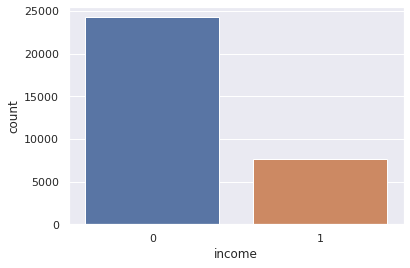

In [51]:
print(data['income'].value_counts())
sns.countplot(x='income', data=data)
plt.show()

A fim de teste, vamos rodar o modelo de Regressão Logística nos dados desbalanceados.

In [52]:
lr = LogisticRegression(max_iter=1000)

In [53]:
x = data.drop('income'  , axis = 1)
y = data.income

In [54]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 1, stratify=y)

In [55]:
lr.fit(x_train, y_train)

LogisticRegression(max_iter=1000)

In [56]:
y_pred = lr.predict(x_test)

In [57]:
print(accuracy_score(y_test, y_pred))

0.8301438398999375


In [58]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.92      0.89      6071
           1       0.69      0.54      0.61      1924

    accuracy                           0.83      7995
   macro avg       0.77      0.73      0.75      7995
weighted avg       0.82      0.83      0.82      7995



In [59]:
print(pd.crosstab(y_test, y_pred, rownames=['Real'], colnames=['Predito'], margins=True))

Predito     0     1   All
Real                     
0        5593   478  6071
1         880  1044  1924
All      6473  1522  7995


Olhando os resultados acima, notamos que o Recall (numero de acertos) é baixa para a classe 1. Ou seja, confirma a teoria que o desbalanceamento fará com que o modelo aprenda mais sobre a classe majoritária.

Sendo assim, vamos usar técnicas para balancear as classes. Como temos uma boa quantidade da classe income = 1, vamos fazer um undersampling (igualar as quantidades de amostras entre as classes).

In [60]:
nr = NearMiss()

Aplicando o NearMiss

In [61]:
x, y = nr.fit_resample(x, y)

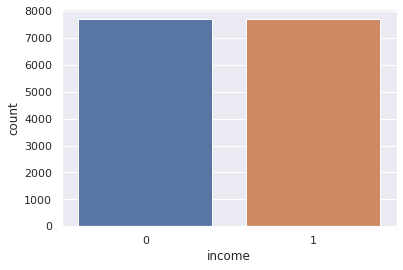

In [62]:
ax = sns.countplot(x=y)

In [63]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 1, stratify=y)

In [64]:
lr = LogisticRegression(max_iter=1000)

In [65]:
lr.fit(x_train, y_train)

LogisticRegression(max_iter=1000)

In [66]:
y_pred = lr.predict(x_test)

In [67]:
print(accuracy_score(y_test, y_pred))

0.7032224532224532


In [68]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.73      0.71      1924
           1       0.71      0.68      0.70      1924

    accuracy                           0.70      3848
   macro avg       0.70      0.70      0.70      3848
weighted avg       0.70      0.70      0.70      3848



In [69]:
print(pd.crosstab(y_test, y_pred, rownames=['Real'], colnames=['Predito'], margins=True))

Predito     0     1   All
Real                     
0        1395   529  1924
1         613  1311  1924
All      2008  1840  3848


In [70]:
smt = SMOTE()

In [71]:
x, y = smt.fit_resample(x, y)

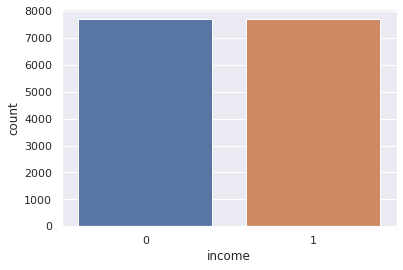

In [72]:
ax = sns.countplot(x=y)

In [73]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 1, stratify=y)

In [74]:
lr = LogisticRegression(max_iter=1000)

In [75]:
lr.fit(x_train, y_train)

LogisticRegression(max_iter=1000)

In [76]:
y_pred = lr.predict(x_test)

In [77]:
print(accuracy_score(y_test, y_pred))

0.7032224532224532


In [78]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.73      0.71      1924
           1       0.71      0.68      0.70      1924

    accuracy                           0.70      3848
   macro avg       0.70      0.70      0.70      3848
weighted avg       0.70      0.70      0.70      3848



In [79]:
print(pd.crosstab(y_test, y_pred, rownames=['Real'], colnames=['Predito'], margins=True))

Predito     0     1   All
Real                     
0        1395   529  1924
1         613  1311  1924
All      2008  1840  3848
